# Forschungsfrage 1 
Im Folgendem wird die Forschungsfrage 1 behandelt.

	Welche Themen werden in Bezug auf das Thema Machine Learning diskutiert?

# Importieren der Module
In der folgenden Zelle werden die benötigten Module, wie zum Beispiel Spacy und scikit-learn importiert.

In [ ]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import matplotlib.pyplot as plt
import spacy 
from spacy.matcher import Matcher
from spacy.tokens import Doc
from spacy.util import filter_spans
import pandas as pd
import re
from collections import Counter
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import copy
import csv



print("imported modules")

Die Konfiguration der unteren Zelle dient der Auswahl der Datensätze. Um alle Datensätze zu erfassen ist start_post = 0 und end_post = 42637 zu setzen

In [2]:
# configuration
start_post = 0
end_post = 42637

# Datensätze laden
Als nächstes müssen die Datensätze aus der exportierten CSV-Datei geladen werden.

In [3]:
# Load csv data
filepath = os.path.join(os.getcwd(), 'QueryResults_sample_42636_14_05_21.csv')

stack_posts = pd.read_csv(filepath, sep = ",")

print("loaded csv data")

loaded csv data


# Hilfsfunktionen
In den folgenden drei Zellen sind verschiedene Hilfsfunktionen abgebildet. Diese werden für das Bereinigen und Filtern der Datensätze benötigt, aber auch für die Verwendung des Tf-Idf-Vectorizers und das Auswählen relavanter Wörter.

Die clean_bodys Funktion bereinigt die Daten anhand eines Regex-Patterns und filtert beispielsweise HTML-Tags heraus.
Die filter_spans Funktion filtert Wortüberlappungen, damit Wörter nicht überzählt werden.

In [4]:
regex_pattern = '(<(pre|code|blockquote|a|strike)(.|\n)*?\/(pre|code|blockquote|a|strike)>)*?|<(p|b|br|br(.|\n)*?\/|sub|sup|em|strong|hr|s|i|ol|ul|li|code)*?>|<\/(p|b|br|sub|sup|em|strong|s|i|ol|ul|li|div|pre|blockquote|a|code)>|<h(.|\n)*?>(.|\n)*?<\/h(.|\n)*?>*?|(<(img|div|ol|ul|li)(.|\n)*?\/*?>)|\n'
def clean_bodys(text):
    text = re.sub(regex_pattern, '', text, flags=re.I)
    text = re.sub('\(|\)', ' ', text, flags=re.I)
    return text

def filter_spans(matches):
    span_list = [doc[match[1]:match[2]] for match in matches]
    filtered_spans = spacy.util.filter_spans(span_list)
    return filtered_spans

Die nächste Zelle zeigt drei verschiedenen Möglichkeiten, wie der Tf-Idf-Vectorizer die relevanten Wörter auswählt.

Diese Möglichkeiten sind:

- Auswahl der Wörter über einen Schwellenwert    
- Auswahl der obersten n Wörter    
- Auswahl der obersten n Prozent der Wörter

Die jeweilige Funktion ist in der Funktion get_relevant_words auszuwählen.

In [5]:
def vectorizer_with_threshold(text_vectorizer):
    threshold = 0.5
    vec = [i for i,value in enumerate(text_vectorizer.toarray()[0]) if value >= threshold]
    return vec

def vectorizer_top_n_words(text_vectorizer):    
    n = 3
    vec = np.argsort(text_vectorizer.toarray()).flatten()[::-1][0:n]        
    return vec


def vectorizer_top_n_percent(text_vectorizer, vec_len):
    percent = 0.15
    #vec_len = len(vectorizer.get_feature_names())
    n = int(vec_len * percent)
    
    vec = np.argsort(text_vectorizer.toarray()).flatten()[::-1][0:n]            
    return vec

In [6]:
def get_relevant_words(text):
    vectorizer = TfidfVectorizer(stop_words = 'english', min_df = 0.5)
    try:
        text_vectorizer = vectorizer.fit_transform([text])
    except:        
        return False
    relevant_words = []    
    feature_array = np.array(vectorizer.get_feature_names())

    tfidf_bigger_than = vectorizer_with_threshold(text_vectorizer)
    #tfidf_bigger_than = vectorizer_with_n_words(text_vectorizer)
    #tfidf_bigger_than = vectorizer_top_n_percent(text_vectorizer, len(feature_array))
    relevant_words.append(feature_array[tfidf_bigger_than])
    return relevant_words
    
def add_words_to_counter(relevant_words, filtered_spans):    
    for word in relevant_words[0]:
        word_doc = nlp(str(word))
        for span in filtered_spans:            
            if word_doc[0].lemma_ in span.lemma_:
                topic_counter[span.lemma_] += 1

# Analyse der Datensätze
Die nächste Zelle zeigt das Finden von Wortzusammensetzungen für jeden einzelnen Datensatz. Diese werden durch ein definiertes Pattern gefunden. Anschließend werden die zuvor beschriebenen Hilfsfunktionen aufgerufen.

In [12]:
# clean posts and match words
nlp = spacy.load("en_core_web_lg")
matcher = Matcher(nlp.vocab)

topic_pattern1 = [{'POS': 'ADJ', 'OP': '?'},
           {'POS': 'NOUN', 'OP': '+'},
           {'POS': 'NOUN', 'OP': '?'}
          ]


word_set = set()

matcher.add("match_topic1", [topic_pattern1])

questions_df = pd.DataFrame(stack_posts[start_post:end_post])
questions_df = questions_df.drop_duplicates(["QuestionId"])

topic_counter = Counter()

for question in questions_df["QuestionBody"][start_post:end_post]:   
    text = clean_bodys(question)
    
    doc = nlp(text)        
    matches = matcher(doc)
    
    filtered_spans = filter_spans(matches)           
    relevant_words = get_relevant_words(text)
    
    if relevant_words == False:
        continue    
    add_words_to_counter(relevant_words, filtered_spans)                
    
                
print("finished questions")
for answer in stack_posts["AnswerBody"][start_post:end_post]: 
    text = clean_bodys(answer) 
    
    doc = nlp(text)     
    matches = matcher(doc)    
    
    filtered_spans = filter_spans(matches)     
    relevant_words = get_relevant_words(text)
    
    if relevant_words == False:
        continue
    add_words_to_counter(relevant_words, filtered_spans)         

print("finished answers")

finished questions
finished answers


# Visualisierung
Die folgende Zelle zeigt die Visualisierung der Ergebnisse. Die Ergebnisse sind im topic_counter enthalten und bigger_than_x_counter limitiert die Ergenbnisse auf die jenigen, die eine Häufigkeit von mindestens 500 haben.
Anschließend werden in der Grafik nur die obersten 10 angezeigt. Ergänzend ist noch zu erwähnen, dass die Ergebnisse "training datum" und "datum" durch "training data" und "data" ersetzt werden. "Datum" ist in diesem Fall das Lemma von Data und wird zur besseren Verständlichkeit durch "Data" ersetzt.

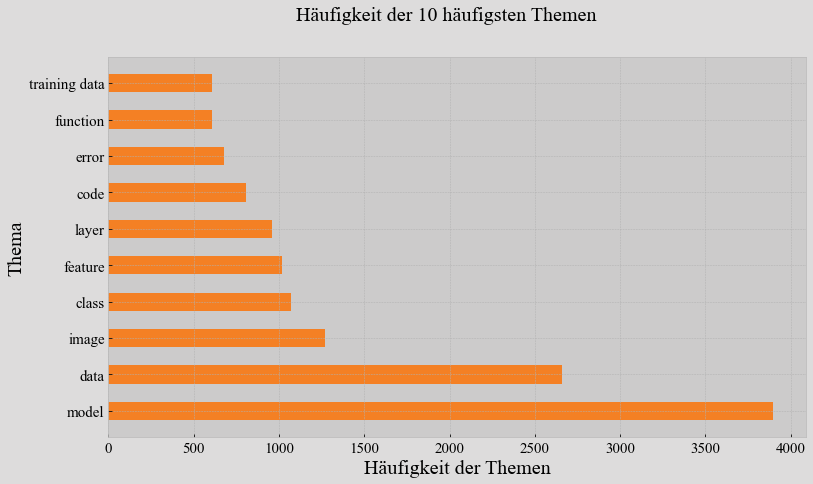

In [22]:
fig_alpha = 0.4
ax_alpha = 0.5
fontsize = 20
line_color = '#F48024'
face_color = '#BCBBBB'
x_ticks = 500

# vectorizer with threshold
training_datum_val = topic_counter['training datum']
datum_val = topic_counter['datum']

del topic_counter['training datum']
del topic_counter['datum']


if training_datum_val != 0 and datum_val != 0:
    topic_counter['training data'] = training_datum_val
    topic_counter['data'] = datum_val


bigger_than_x_counter = Counter({k: c for k,c in sorted(topic_counter.items(), key=lambda item: item[1], reverse=True)if c >= 500})

keys = list(bigger_than_x_counter.keys())[0:10]
values = list(bigger_than_x_counter.values())[0:10]

plt.style.use('bmh')
plt.rcParams["font.family"] = 'Times New Roman'

fig, ax = plt.subplots(figsize=(12.5,7))
fig.patch.set_facecolor('#BCBBBB')
fig.patch.set_alpha(ax_alpha)

plt.suptitle('Häufigkeit der 10 häufigsten Themen', fontsize=fontsize)
plt.xticks(np.arange(0, max(values)+x_ticks, x_ticks))
plt.xlabel('Häufigkeit der Themen', fontsize=fontsize)
plt.ylabel('Thema', fontsize=fontsize)

ax.patch.set_facecolor(face_color)
ax.patch.set_alpha(ax_alpha)
ax.tick_params(axis='y', labelsize=fontsize-5)
ax.tick_params(axis='x', labelsize=fontsize-5)
ax.barh(keys, values, height=0.5, color='#F48024')

plt.savefig('top_10.png', bbox_inches='tight', pad_inches=0.2)

In [ ]:
# vectorizer with percent
bigger_than_x_counter = Counter({k: c for k,c in sorted(topic_counter.items(), key=lambda item: item[1], reverse=True) if c >= 100})

keys = list(bigger_than_x_counter.keys())
values = bigger_than_x_counter.values()

fig, ax = plt.subplots(figsize=(30,30))
plt.xticks(np.arange(0, max(values)+250, 250.0))
#ax.xaxis.tick_top()
plt.xlabel('Häufigkeit der Themen')
plt.ylabel('Thema')
ax.barh(keys, values)
